# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Fall 2019

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
import cv2
import numpy as np
from numpy.linalg import svd, inv

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# images location
im1 = './images/input/frames/f0450.jpg'
im2 = './images/input/frames/f0270.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im2 = cv2.imread(im2)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [3]:
def auto_homography(Ia,Ib, homography_func=None, normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 5  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    N = pts1.shape[1]
    A = np.zeros((2*N,9))
    
    for i in range(N):
        x = pts1[:, i]
        x_p = pts2[:, i]
        u,v = x[0], x[1]
        u_p,v_p = x_p[0], x_p[1]
        A[2*i,:] = np.array([-u, -v, -1, 0, 0, 0, u*u_p, v*u_p, u_p])
        A[2*i+1, :] = np.array([0, 0, 0, -u, -v, -1, u*v_p, v*v_p, v_p])
    
    _,_,V = np.linalg.svd(A)
    h = V[V.shape[0]-1,:]
    H_n = np.reshape(h, (3,3))
    return H_n

In [5]:
H = auto_homography(im2,im1, computeHomography)

best score: 163.000000


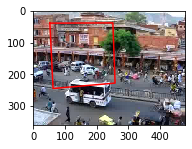

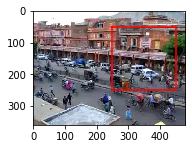

In [6]:
rectangle_points_dim_0 = np.array([250, 450, 450, 250, 250])
rectangle_points_dim_1 = np.array([50,50,250, 250,50])
vector_of_ones = np.ones(5)
rectan = np.array([rectangle_points_dim_0,rectangle_points_dim_1, vector_of_ones])
rectan_projected = np.dot(H, rectan)
rectan_projected = rectan_projected / rectan_projected[-1]

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(im1)
ax1.plot(rectan_projected[0], rectan_projected[1], 'r')

fig2 = plt.figure()
ax1 = fig2.add_subplot(1, 2, 1)
plt.imshow(im2)
ax1.plot(rectangle_points_dim_0, rectangle_points_dim_1, 'r')

In [7]:
rectangle_points_dim_0 = np.array([250, 450, 450, 250, 250])
rectangle_points_dim_1 = np.array([50,50,250, 250,50])
vector_of_ones = np.ones(5)
rectan = np.array([rectangle_points_dim_0,rectangle_points_dim_1, vector_of_ones])
rectan_projected = np.dot(H, rectan)
rectan_projected = rectan_projected / rectan_projected[-1]

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(im1)
ax1.plot(rectan_projected[0], rectan_projected[1], 'r')

fig2 = plt.figure()
ax1 = fig2.add_subplot(1, 2, 1)
plt.imshow(im2)
ax1.plot(rectangle_points_dim_0, rectangle_points_dim_1, 'r')

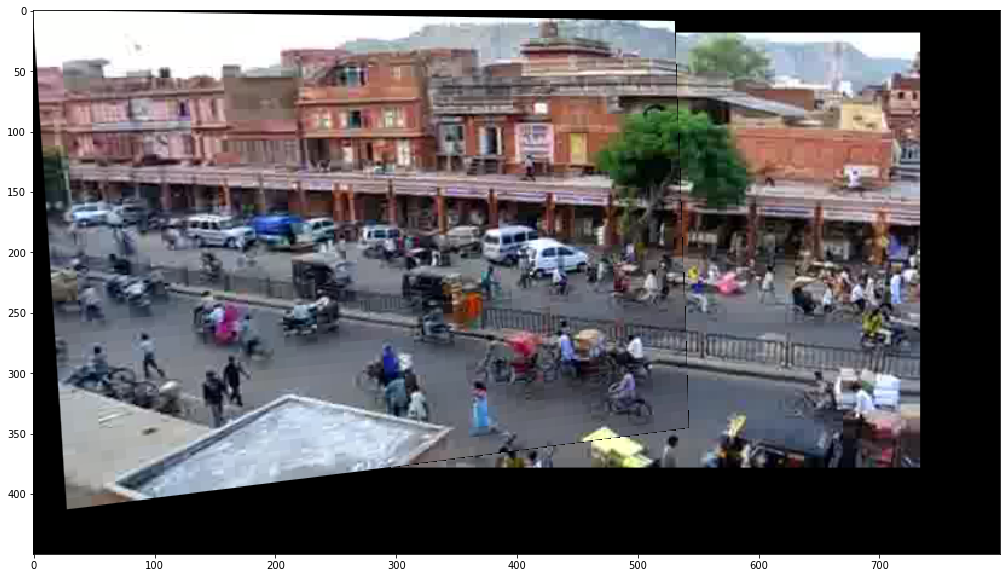

In [8]:
plt.figure(figsize=(60,10))
plt.imshow(out)

### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [9]:
import cv2
import numpy as np

In [10]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)

im1 = cv2.imread('./images/input/frames/f0090.jpg')
im2 = cv2.imread('./images/input/frames/f0270.jpg')
im3 = cv2.imread('./images/input/frames/f0450.jpg')
im4 = cv2.imread('./images/input/frames/f0630.jpg')
im5 = cv2.imread('./images/input/frames/f0810.jpg')

best score: 159.000000
best score: 209.000000
best score: 137.000000
best score: 96.000000


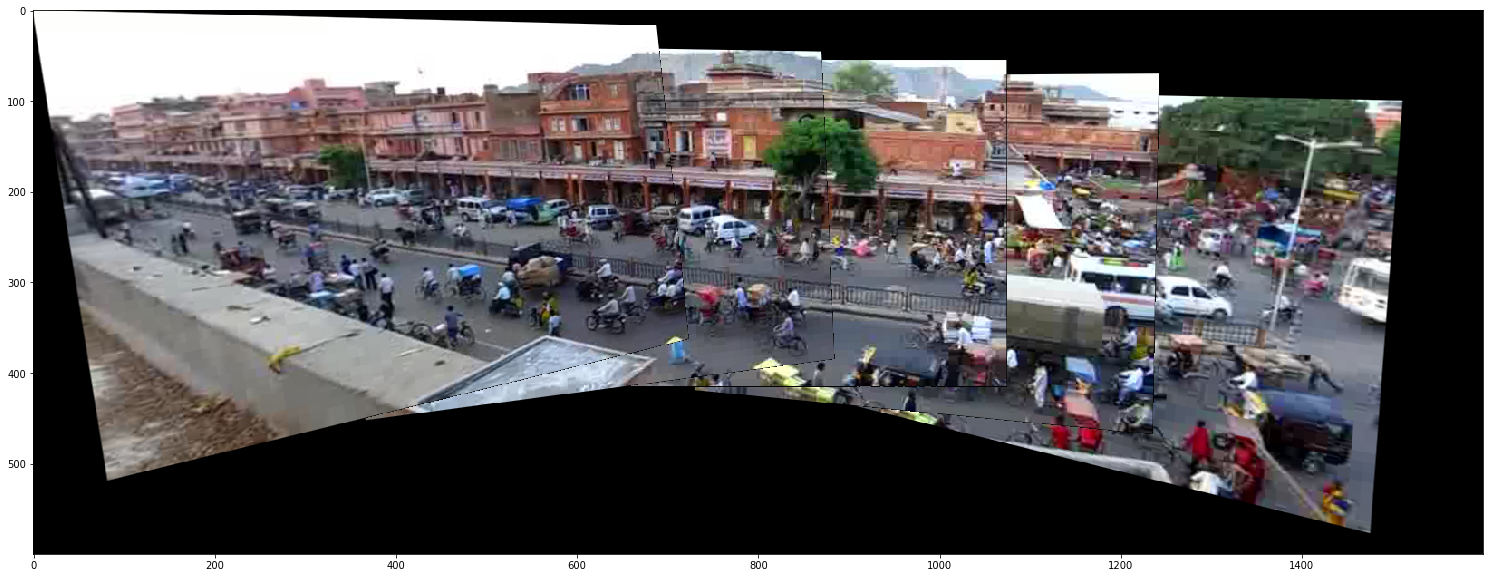

In [12]:
H_1 = auto_homography(im2,im3, computeHomography)

H_2 = auto_homography(im1,im2, computeHomography)
left = np.matmul(H_1, H_2)

H_3 = auto_homography(im4,im3, computeHomography)
H_4 = auto_homography(im5,im4, computeHomography)
right = np.matmul(H_3, H_4)

corners = np.array([[0, 0, 1], [360, 0, 1], [0, 480, 1], [360, 480, 1]])
corners_t = h90@corners.T
holder = np.zeros((3,4))
holder[0] = corners_t[0]/corners_t[2]
holder[1] = corners_t[1]/corners_t[2]

H_t = np.identity(3)
offset_x = min(corners_t[0])
offset_y = min(corners_t[1])
H_t[0][2] = offset_x
H_t[1][2] = offset_y

img_warped2 = cv2.warpPerspective(frame90, H_t.dot(h90), (1600, 600))
img_warped3 = cv2.warpPerspective(frame270, H_t.dot(h270), (1600, 600))
img_warped4 = cv2.warpPerspective(frame630, H_t.dot(h630), (1600, 600))
img_warped5 = cv2.warpPerspective(frame810, H_t.dot(h810), (1600, 600))

img_warped = cv2.warpPerspective(frame450, H_t, (1600,600))
out = np.zeros((600,1600,3))
h, w, _ = img_warped.shape
for r in range(h):
    for c in range(w):
        out[r][c] = img_warped2[r][c]
for r in range(h):
    for c in range(w):
        if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
            out[r][c] = img_warped3[r][c]
for r in range(h):
    for c in range(w):
        if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
            out[r][c] = img_warped[r][c]
for r in range(h):
    for c in range(w):
        if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
            out[r][c] = img_warped4[r][c]
for r in range(h):
    for c in range(w):
        if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
            out[r][c] = img_warped5[r][c]

plt.figure(figsize=(60,10))
plt.imshow(out)

### Part 3: Map the video to the reference plane

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

import utils

In [14]:
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [15]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [16]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [17]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0
cv2.imwrite('test.jpg', frames[6])

True

In [18]:
print(len(frames))

900


In [19]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
sourceFrameIndex = 630
referenceFrameIndex = 450

In [20]:
pics = np.zeros((900, 512, 1632, 3), dtype=np.float64)
for i in range(0,450):
    projectedSource, _, originTranslations = utils.projectImage(frames, i, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    cv2.imwrite('aligned_frames/a{:04d}.jpg'.format(i), cv2.cvtColor(projectedSource, cv2.COLOR_RGB2BGR))
    pics[i] = projectedSource
    
    
    projectedSource, _, originTranslations = utils.projectImage(frames, 899-i, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    cv2.imwrite('aligned_frames/a{:04d}.jpg'.format(899-i), cv2.cvtColor(projectedSource, cv2.COLOR_RGB2BGR))
    pics[899-i] = projectedSource

best score: 2630.000000
best score: 31.000000
Overlap:24027
Error:0.000721365812649741
Finding better homography...
best score: 66.000000
Overlap:40775
Error:0.000514004950445048
best score: 2751.000000
best score: 259.000000
Overlap:147943
Error:0.00018572406415419865
Found better homography
best score: 34.000000
Overlap:32662
Error:0.0006187181140688344
Finding better homography...
best score: 53.000000
Overlap:58594
Error:0.0004363384861549097
best score: 3035.000000
best score: 141.000000
Overlap:137773
Error:0.0002984603086788812
Found better homography
best score: 29.000000
Overlap:24693
Error:0.00072994170726854
Finding better homography...
best score: 62.000000
Overlap:40673
Error:0.0005219258497802839
best score: 2755.000000
best score: 280.000000
Overlap:148074
Error:0.00018530891478533157
Found better homography
best score: 20.000000
Overlap:32824
Error:0.0006304777361011403
Finding better homography...
best score: 53.000000
Overlap:57915
Error:0.000447713000168635
best scor

best score: 3205.000000
best score: 170.000000
Overlap:147045
Error:0.00029444689474877666
Found better homography
best score: 41.000000
Overlap:27256
Error:0.0007309352843947846
Finding better homography...
best score: 74.000000
Overlap:42731
Error:0.0005267202952764918
best score: 2609.000000
best score: 303.000000
Overlap:148952
Error:0.0001803452466552077
Found better homography
best score: 24.000000
Overlap:41255
Error:0.0005189513061874888
Finding better homography...
best score: 52.000000
Overlap:57003
Error:0.00043263537641693463
best score: 3178.000000
best score: 142.000000
Overlap:148749
Error:0.00029215141223058993
Found better homography
best score: 39.000000
Overlap:27496
Error:0.0007047876665574564
Finding better homography...
best score: 60.000000
Overlap:43654
Error:0.0005102075083880017
best score: 2610.000000
best score: 295.000000
Overlap:149072
Error:0.00017649887073897992
Found better homography
best score: 31.000000
Overlap:41658
Error:0.0005216329502053815
Findi

best score: 57.000000
Overlap:58117
Error:0.0004574224703135154
best score: 3180.000000
best score: 156.000000
Overlap:146223
Error:0.0002946549755494945
Found better homography
best score: 36.000000
Overlap:24727
Error:0.0007945275795949153
Finding better homography...
best score: 70.000000
Overlap:44839
Error:0.0004941188544726381
best score: 2610.000000
best score: 228.000000
Overlap:146737
Error:0.00018572011120057604
Found better homography
best score: 32.000000
Overlap:41825
Error:0.0005220289694818232
Finding better homography...
best score: 64.000000
Overlap:59271
Error:0.00042881600251417934
best score: 3187.000000
best score: 166.000000
Overlap:145755
Error:0.00029485553094968787
Found better homography
best score: 41.000000
Overlap:25003
Error:0.0007596236097619982
Finding better homography...
best score: 68.000000
Overlap:45677
Error:0.0004892278665014032
best score: 2449.000000
best score: 262.000000
Overlap:146100
Error:0.0001901574998575277
Found better homography
best s

best score: 35.000000
Overlap:43951
Error:0.0005218607435169533
Finding better homography...
best score: 62.000000
Overlap:65379
Error:0.0004270376528642237
best score: 3015.000000
best score: 144.000000
Overlap:141881
Error:0.0002995878321967019
Found better homography
best score: 34.000000
Overlap:27248
Error:0.0007459522575768529
Finding better homography...
best score: 75.000000
Overlap:50649
Error:0.0004767773026584726
best score: 2602.000000
best score: 246.000000
Overlap:140614
Error:0.00019912485679513109
Found better homography
best score: 45.000000
Overlap:44554
Error:0.0005077859884858751
Finding better homography...
best score: 61.000000
Overlap:66129
Error:0.0004247661450042463
best score: 3191.000000
best score: 161.000000
Overlap:143109
Error:0.00029443268202616673
Found better homography
best score: 40.000000
Overlap:27240
Error:0.0007357264164443798
Finding better homography...
best score: 75.000000
Overlap:52131
Error:0.0004600243602508028
best score: 2558.000000
best

best score: 2687.000000
best score: 250.000000
Overlap:140647
Error:0.00019750063079869442
Found better homography
best score: 36.000000
Overlap:49258
Error:0.0004992866382120971
Finding better homography...
best score: 58.000000
Overlap:67991
Error:0.00045089354133663904
best score: 3091.000000
best score: 164.000000
Overlap:145344
Error:0.0003006444632469877
Found better homography
best score: 52.000000
Overlap:31542
Error:0.0006730527941311039
Finding better homography...
best score: 77.000000
Overlap:54280
Error:0.0004683099163712125
best score: 2633.000000
best score: 264.000000
Overlap:141239
Error:0.00020040841292624022
Found better homography
best score: 35.000000
Overlap:49805
Error:0.0005021638650289223
Finding better homography...
best score: 78.000000
Overlap:67920
Error:0.00044676731207877524
best score: 3099.000000
best score: 181.000000
Overlap:145689
Error:0.0002986228998585687
Found better homography
best score: 47.000000
Overlap:32936
Error:0.0006970010633167887
Findi

best score: 87.000000
Overlap:57647
Error:0.0004497269940734348
best score: 2755.000000
best score: 248.000000
Overlap:140325
Error:0.00019386390733213294
Found better homography
best score: 46.000000
Overlap:54424
Error:0.0004707069018557495
Finding better homography...
best score: 78.000000
Overlap:72568
Error:0.00043504349527321613
best score: 2935.000000
best score: 160.000000
Overlap:146347
Error:0.0003033199636110771
Found better homography
best score: 48.000000
Overlap:33488
Error:0.0005901467510103467
Finding better homography...
best score: 79.000000
Overlap:56913
Error:0.00045431918009998355
best score: 2669.000000
best score: 240.000000
Overlap:141811
Error:0.00019797324314825644
Found better homography
best score: 48.000000
Overlap:53440
Error:0.00048787992565052404
Finding better homography...
best score: 78.000000
Overlap:73488
Error:0.00043238148074851074
best score: 3066.000000
best score: 173.000000
Overlap:144899
Error:0.00030740014680111986
Found better homography
be

best score: 62.000000
Overlap:37899
Error:0.0005931579864426922
Finding better homography...
best score: 73.000000
Overlap:59858
Error:0.00044561590459292965
best score: 2631.000000
best score: 217.000000
Overlap:141924
Error:0.00019643215045578695
Found better homography
best score: 50.000000
Overlap:53626
Error:0.0004920781800990967
Finding better homography...
best score: 71.000000
Overlap:77044
Error:0.00041969237058037053
best score: 2929.000000
best score: 159.000000
Overlap:138129
Error:0.00032708986036203316
Found better homography
best score: 58.000000
Overlap:38099
Error:0.0005910431515262699
Finding better homography...
best score: 74.000000
Overlap:59921
Error:0.0004504780437281964
best score: 2569.000000
best score: 245.000000
Overlap:142604
Error:0.00019770064393351267
Found better homography
best score: 51.000000
Overlap:53807
Error:0.00048266462312838906
Finding better homography...
best score: 83.000000
Overlap:77621
Error:0.0004218687266951754
best score: 2901.000000


Overlap:82924
Error:0.00042280849047047673
best score: 169.000000
Overlap:137711
Error:0.00033447560088962857
Found better homography
best score: 46.000000
Overlap:40957
Error:0.0005215586321904535
Finding better homography...
best score: 93.000000
Overlap:64442
Error:0.0004298787658187438
best score: 2582.000000
best score: 213.000000
Overlap:140770
Error:0.0001997116692034283
Found better homography
best score: 53.000000
Overlap:58093
Error:0.00044699073967360733
Finding better homography...
best score: 80.000000
Overlap:82747
Error:0.0004225213480008581
best score: 2811.000000
best score: 163.000000
Overlap:137268
Error:0.00033543348238767115
Found better homography
Overlap:40775
Error:0.0005140053217804135
Finding better homography...
best score: 101.000000
Overlap:65598
Error:0.00043015116916664915
best score: 2654.000000
best score: 210.000000
Overlap:139760
Error:0.00019940015246142624
Found better homography
best score: 54.000000
Overlap:57800
Error:0.0004557028939968069
Findin

Overlap:55296
Error:0.000458507816096493
Finding better homography...
Overlap:86905
Error:0.00045099384845168755
best score: 136.000000
Overlap:130678
Error:0.0003673716725781907
Found better homography
Overlap:43393
Error:0.0004996862384481108
Finding better homography...
best score: 113.000000
Overlap:70595
Error:0.0004235417878208023
best score: 2814.000000
best score: 212.000000
Overlap:137065
Error:0.00020407432173596534
Found better homography
Overlap:55642
Error:0.0004487917476747314
Finding better homography...
best score: 85.000000
Overlap:87175
Error:0.00044883351467399384
best score: 2759.000000
best score: 140.000000
Overlap:129492
Error:0.0003712377000659708
Overlap:120795
Error:0.000352354177316341
best score: 102.000000
Overlap:96424
Error:0.0004240255172000644
Found better homography
Overlap:43430
Error:0.0004972708553242689
Finding better homography...
best score: 97.000000
Overlap:70320
Error:0.00043022112859781366
best score: 2783.000000
best score: 202.000000
Overla

/home/kazukis2/anaconda3/envs/cv3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/home/kazukis2/anaconda3/envs/cv3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


best score: 130.000000
Overlap:70222
Error:0.00042621584521428937
best score: 2889.000000
best score: 214.000000
Overlap:137355
Error:0.0002023141299617438
Found better homography
Overlap:57981
Error:0.00044710421989844806
Finding better homography...
best score: 76.000000
Overlap:87427
Error:0.0004471631820015126
best score: 2779.000000
best score: 146.000000
Overlap:131636
Error:0.0003717762776936727
best score: 143.000000
Overlap:122324
Error:0.0003474225156405323
best score: 2763.000000
best score: 107.000000
Overlap:96894
Error:0.0004192797894090077
Found better homography
Overlap:44905
Error:0.00048524228016806186
Finding better homography...
best score: 113.000000
Overlap:69730
Error:0.00043504797097863363
best score: 2860.000000
best score: 192.000000
Overlap:138307
Error:0.00020439738756337873
Found better homography
Overlap:57331
Error:0.00045467846741090867
Finding better homography...
best score: 86.000000
Overlap:88530
Error:0.00044318538070159044
best score: 2849.000000
b

Overlap:52645
Error:0.00046932573117463005
Finding better homography...
Overlap:76533
Error:0.00040504882321324283
best score: 189.000000
Overlap:139529
Error:0.0002018942345325814
Found better homography
Overlap:64683
Error:0.00043266961013634195
Finding better homography...
Overlap:91989
Error:0.0004456813058883045
best score: 155.000000
Overlap:135233
Error:0.0003634694040820999
Overlap:126662
Error:0.00033512664424468645
best score: 108.000000
Overlap:100821
Error:0.00041355823573459305
Found better homography
Overlap:50585
Error:0.0004869671199851424
Finding better homography...
best score: 101.000000
Overlap:75821
Error:0.00039842698845610094
best score: 2837.000000
best score: 191.000000
Overlap:140519
Error:0.00020077524275024914
Found better homography
Overlap:65173
Error:0.00042165511483620673
Finding better homography...
best score: 95.000000
Overlap:93168
Error:0.00044286101842019626
best score: 2783.000000
best score: 152.000000
Overlap:135200
Error:0.00036192195334178894


Overlap:55119
Error:0.0004514265643924859
Finding better homography...
best score: 125.000000
Overlap:80049
Error:0.00040662666190477724
best score: 2878.000000
best score: 218.000000
Overlap:138572
Error:0.00020079322041078568
Found better homography
Overlap:67920
Error:0.0004467681589751127
Finding better homography...
best score: 100.000000
Overlap:97229
Error:0.00042929266697589764
best score: 2801.000000
best score: 159.000000
Overlap:134238
Error:0.0003606268847877502
Found better homography
Overlap:54550
Error:0.0004577226757154198
Finding better homography...
Overlap:80049
Error:0.0004066260966481336
best score: 219.000000
Overlap:136484
Error:0.0002047447670596236
Found better homography
Overlap:68848
Error:0.00045192146988860615
Finding better homography...
Overlap:97229
Error:0.0004292928984596105
best score: 174.000000
Overlap:134012
Error:0.0003604391314310097
Found better homography
Overlap:54985
Error:0.00045823610559181567
Finding better homography...
best score: 112.00

best score: 185.000000
Overlap:137923
Error:0.0002097703176851216
Found better homography
Overlap:75284
Error:0.00043640803985578404
Finding better homography...
Overlap:104722
Error:0.00039579123099819317
best score: 190.000000
Overlap:134818
Error:0.00036400992266881905
Found better homography
Overlap:58539
Error:0.0004532998246438165
Finding better homography...
best score: 133.000000
Overlap:86892
Error:0.0003724962443567101
best score: 2766.000000
best score: 180.000000
Overlap:137334
Error:0.00020823082274575122
Found better homography
Overlap:75615
Error:0.0004345488384317059
Finding better homography...
best score: 89.000000
Overlap:105258
Error:0.00039303546493689136
best score: 2574.000000
best score: 153.000000
Overlap:133832
Error:0.00036641925616489923
Found better homography
Overlap:58749
Error:0.0004537737537369846
Finding better homography...
best score: 119.000000
Overlap:86549
Error:0.0003689887389723585
best score: 2708.000000
best score: 180.000000
Overlap:137157
Er

Overlap:82924
Error:0.00042280849047047673
Finding better homography...
best score: 121.000000
Overlap:110598
Error:0.00039028913169696143
best score: 2677.000000
best score: 181.000000
Overlap:135306
Error:0.00034735497673827833
Found better homography
Overlap:65598
Error:0.000430151629394843
Finding better homography...
best score: 138.000000
Overlap:91417
Error:0.00035028102494539593
best score: 2821.000000
best score: 199.000000
Overlap:138352
Error:0.00021253851228110655
Found better homography
Overlap:82747
Error:0.0004225214689737049
Finding better homography...
best score: 120.000000
Overlap:111121
Error:0.0003897058832638066
best score: 2685.000000
best score: 166.000000
Overlap:133546
Error:0.0003504551596955524
Found better homography
Overlap:66458
Error:0.00042618320454845593
Finding better homography...
best score: 130.000000
Overlap:92652
Error:0.00035269583191307227
best score: 2746.000000
best score: 219.000000
Overlap:138371
Error:0.00021248673929640603
Found better ho

best score: 107.000000
Overlap:112610
Error:0.00038953930281376896
best score: 2750.000000
best score: 193.000000
Overlap:138907
Error:0.00034497204451887505
Found better homography
Overlap:69314
Error:0.000440084636905164
Finding better homography...
best score: 146.000000
Overlap:97183
Error:0.0003316238857363916
best score: 2829.000000
best score: 207.000000
Overlap:139004
Error:0.00021329052503872076
Found better homography
Overlap:88530
Error:0.0004431854655587551
Finding better homography...
best score: 127.000000
Overlap:112839
Error:0.00038438230404465383
best score: 2736.000000
best score: 167.000000
Overlap:139133
Error:0.00034415429470879735
Found better homography
Overlap:71517
Error:0.0004232023146214598
Finding better homography...
Overlap:97183
Error:0.0003316225683951819
best score: 209.000000
Overlap:140869
Error:0.00021165251665170915
Found better homography
Overlap:88345
Error:0.00044683552089086546
Finding better homography...
Overlap:112839
Error:0.0003843822153439

best score: 170.000000
Overlap:142160
Error:0.0003457064623717582
Found better homography
Overlap:80049
Error:0.0004066260966481336
Finding better homography...
best score: 151.000000
Overlap:101630
Error:0.00032963721104698374
best score: 2691.000000
best score: 223.000000
Overlap:144672
Error:0.00020851921924783752
Found better homography
Overlap:97291
Error:0.00042626572004755294
Finding better homography...
Overlap:120359
Error:0.00035294815859958785
best score: 153.000000
Overlap:142937
Error:0.00034426464471493833
Found better homography
Overlap:80318
Error:0.0004019736793534568
Finding better homography...
Overlap:101630
Error:0.0003296373594407713
best score: 210.000000
Overlap:145269
Error:0.0002125342763792812
Found better homography
Overlap:97229
Error:0.0004292928984596105
Finding better homography...
Overlap:120359
Error:0.00035294815859958785
best score: 159.000000
Overlap:143031
Error:0.00034319197330765844
Found better homography
Overlap:81652
Error:0.000399169897230760

Overlap:123776
Error:0.00034416600596888004
best score: 141.000000
Overlap:105550
Error:0.0003167251927963038
Overlap:124314
Error:0.00034575837274639147
best score: 150.000000
Overlap:106124
Error:0.0003114017556630865
Overlap:125177
Error:0.0003422093927394866
best score: 163.000000
Overlap:106950
Error:0.0003106943484644645
Overlap:125519
Error:0.00033885614456186726
best score: 162.000000
Overlap:107818
Error:0.00031017934061772836
Overlap:126662
Error:0.00033512664424468645
best score: 168.000000
Overlap:107454
Error:0.0003098851608918962
Overlap:127373
Error:0.0003362404037396521
best score: 163.000000
Overlap:108244
Error:0.0003144206070530332
Overlap:127734
Error:0.00033111494197894545
best score: 167.000000
Overlap:108146
Error:0.0003110948799931901
Overlap:127500
Error:0.0003293964010065963
best score: 163.000000
Overlap:107746
Error:0.0003116532947395638
Overlap:127617
Error:0.0003282346183225251
best score: 151.000000
Overlap:109437
Error:0.0003095364899858798
Overlap:12847

best score: 201.000000
Overlap:135204
Error:0.0002616689916528118
best score: 190.000000
Overlap:137191
Error:0.00029228905628726147
best score: 205.000000
Overlap:136274
Error:0.0002619353251181293
best score: 187.000000
Overlap:137790
Error:0.00028973877775725963
best score: 201.000000
Overlap:136184
Error:0.0002624475994943786
best score: 190.000000
Overlap:138845
Error:0.0002892375840342738
best score: 216.000000
Overlap:136260
Error:0.00026506850442725824
best score: 185.000000
Overlap:139093
Error:0.0002843480627584862
best score: 207.000000
Overlap:137730
Error:0.000263387108631741
best score: 189.000000
Overlap:139362
Error:0.00028116563899435715
best score: 211.000000
Overlap:135841
Error:0.00026218400373515346
best score: 200.000000
Overlap:139945
Error:0.0002789886942322716
best score: 189.000000
Overlap:133581
Error:0.00026527929156841947
best score: 215.000000
Overlap:140739
Error:0.0002758932937369606
best score: 195.000000
Overlap:134621
Error:0.00026554786480917673
best

best score: 226.000000
Overlap:162060
Error:0.00024489769628361236
best score: 241.000000
Overlap:155812
Error:0.00025835062224178264
best score: 248.000000
Overlap:162938
Error:0.0002430372976965561
best score: 242.000000
Overlap:156252
Error:0.00025637259543738
best score: 249.000000
Overlap:163138
Error:0.00024024824376826911
best score: 246.000000
Overlap:156890
Error:0.0002533553536716179
best score: 265.000000
Overlap:163519
Error:0.00023619530604381542
best score: 262.000000
Overlap:157206
Error:0.00025296259780904117
best score: 247.000000
Overlap:164077
Error:0.0002364523034672815
best score: 270.000000
Overlap:156798
Error:0.00024921304108519387
best score: 257.000000
Overlap:163820
Error:0.00023697239193045752
best score: 265.000000
Overlap:157624
Error:0.00025039426914840644
best score: 248.000000
Overlap:164865
Error:0.00023863447260869192
best score: 296.000000
Overlap:158340
Error:0.000246653986828774
best score: 286.000000
Overlap:164343
Error:0.00023549306824093136
bes

In [21]:
utils.imageFolder2mpeg('aligned_frames', fps=30)

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pdb

ht, wd = projected[0].shape[0], projected[0].shape[1]
# vectorized approach
median_calc = np.zeros((ht,wd,3,len(projected)))
median_calc.fill(np.nan)
frame,x,y,c = np.nonzero(projected)
median_calc[x,y,c,frame] = projected[frame,x,y,c]
median = np.nanmedian(median_calc,axis=3)
plt.imshow(median*255)

In [ ]:
plt.figure(figsize=(60,10))
plt.imshow(median/255)

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [ ]:
import os
import cv2
import numpy as np

warped_imgs = np.zeros((900,360,480,3))
for i in range(0, 900):
    cur_H = pastHomographies[i][450]
    inv_H = np.linalg.inv(cur_H)
    median = median.astype('uint8')
    img_warped = cv2.warpPerspective(median, inv_H, (480, 360))
    warped_imgs[i,:,:,:] = img_warped
    cv2.imwrite('part5_frames/a{:04d}.jpg'.format(i), cv2.cvtColor(img_warped, cv2.COLOR_RGB2BGR))

In [ ]:
utils.imageFolder2mpeg('part5_frames', fps=30)

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [ ]:
import os
import cv2
import numpy as np

for i in range(0, 900):
    difference = frames[i] - (warped_imgs[i]/255)
    cv2.imwrite('part6_frames/a{:04d}.jpg'.format(i), difference*255)

In [ ]:
utils.imageFolder2mpeg('part6_frames', fps=30)

## Bells and whistles